# Stochastic heart

In [12]:
import numpy as np

import matplotlib.pyplot as plt
import networkx as nx
from tqdm import tqdm
# import sparse matrices
from scipy.sparse import csr_matrix
import sdeint as sde
import os, sys
from scipy.sparse import diags, coo_matrix
from scipy import sparse
import jax.numpy as jnp
from diffrax import diffeqsolve, ODETerm, SaveAt, Tsit5, Dopri5, PIDController
import diffrax
import jax
from jax import vmap, random, jit
from jax import lax, ops
from jax.experimental import sparse
rootpath = os.path.join(os.getcwd(), '..')
sys.path.append(rootpath)

In [13]:


def generate_laplacian(N, M, conduction_block_threshold, sparse_matrix=False, seed=0):
    '''
    Generate a Laplacian matrix for a 2D grid with conduction blocks.
    The Laplacian matrix is generated using a nine-point stencil with weights.
    The conduction blocks are randomly generated with a given threshold.
    Parameters:
    - N: number of rows in the grid
    - M: number of columns in the grid
    - conduction_block_threshold: threshold below which a point in the grid is considered a conduction block
    - sparse_matrix: whether to return a sparse matrix or a dense matrix
    - seed: seed for the random number generator
    Returns:
    - Laplacian matrix: jax matrix as a sparse or dense matrix
    - conduction blocks: boolean matrix
    '''
    num_nodes = N * M
    adj_rows = []
    adj_cols = []
    adj_data = []

    # Generate random conduction blocks
    np.random.seed(seed)
    conduction_blocks = np.random.rand(N, M) < conduction_block_threshold

    # Function to map grid (i, j) to a single node index
    def node_index(i, j):
        return i * M + j

    # Define neighbors for the nine-point stencil with weights
    neighbors = [
        (-1, 0, .5),     # up
        (1, 0, .5),      # down
        (0, -1, .5),     # left
        (0, 1, .5),      # right
        (-1, -1, .25),   # top-left
        (-1, 1, .25),    # top-right
        (1, -1, .25),    # bottom-left
        (1, 1, .25)      # bottom-right
    ]
    
    # Build adjacency structure excluding conduction blocks
    indices = np.array([[i, j] for i in range(N) for j in range(M)])
    idx = node_index(indices[:, 0], indices[:, 1])

    for di, dj, weight in neighbors:
        ni = indices[:, 0] + di
        nj = indices[:, 1] + dj

    # Step 1: Filter for in-bounds neighbors
        in_bounds = (ni >= 0) & (ni < N) & (nj >= 0) & (nj < M)
    
    # Step 2: Find valid indices (in-bounds) to avoid shape mismatches
        valid_indices = np.where(in_bounds)[0]
        ni_valid = ni[valid_indices]
        nj_valid = nj[valid_indices]

    # Step 3: Apply conduction block exclusion on the filtered indices
        valid_conduction = ~conduction_blocks[ni_valid, nj_valid]
        valid_node = ~conduction_blocks[indices[valid_indices, 0], indices[valid_indices, 1]]
        valid = valid_conduction & valid_node

    # Step 4: Append data for fully valid connections
        adj_rows.extend(idx[valid_indices][valid])
        adj_cols.extend(node_index(ni_valid[valid], nj_valid[valid]))
        adj_data.extend([weight] * int(np.sum(valid)))


    # Create adjacency and degree matrices
    adj_matrix = coo_matrix((adj_data, (adj_rows, adj_cols)), shape=(num_nodes, num_nodes))
    degrees = np.array(adj_matrix.sum(axis=1)).flatten()
    degree_matrix = diags(degrees)

    # Construct Laplacian matrix
    laplacian_matrix = degree_matrix - adj_matrix


    if sparse_matrix:

        return sparse.BCSR.from_scipy_sparse(laplacian_matrix), conduction_blocks
    
    else:
        return laplacian_matrix.todense(), jnp.array(conduction_blocks)

N_x=200
N_y=200
N=N_x*N_y
L1, c1=generate_laplacian(N_x, N_x, 0.5, sparse_matrix=True,seed=2)


In [ ]:
import scipy.sparse as sp
from scipy.sparse.linalg import eigsh

#calculate the spectral radius of the Laplacian matrix 
def bcsr_to_scipy(jax_bcsr):
    """
    Convert a JAX BCSR sparse matrix to a SciPy sparse matrix.
    """
    # Extract data, indices, and indptr from the JAX sparse matrix
    data = jax_bcsr.data
    indices = jax_bcsr.indices
    indptr = jax_bcsr.indptr
    shape = jax_bcsr.shape

    # Reconstruct the SciPy CSR matrix
    scipy_matrix = sp.csr_matrix((data, indices, indptr), shape=shape)
    return scipy_matrix
# Compute the spectral radius using SciPy's eigsh
def compute_spectral_radius(L):
    # Use eigsh to compute the largest eigenvalue magnitude
    L=bcsr_to_scipy(L)
    eigenvalues, _ = eigsh(L, k=1, which="LM")
    spectral_radius = np.abs(eigenvalues[0])
    return spectral_radius


# Calculate spectral radius
rho_L = compute_spectral_radius(L1)

# Print result
print(f"Spectral Radius of L: {rho_L}")

Spectral Radius of L: 3.880535125732422


In [ ]:
# Compute the smallest eigenvalue magnitude of the Laplacian matrix
def compute_min_abs_eigenvalue(jax_bcsr):
    # Convert to SciPy sparse matrix
    scipy_matrix = bcsr_to_scipy(jax_bcsr)
    
    # Compute eigenvalues with smallest magnitude
    eigenvalues, _ = eigsh(scipy_matrix, k=1, which="SM")
    min_abs_eigenvalue = np.abs(eigenvalues[0])
    return min_abs_eigenvalue
print(compute_min_abs_eigenvalue(L1))

6.0295605e-08


In [ ]:
# integration of the FHN for the coupled system
def FHN_step(u, v, N, a, b, e, Du, sigma, L, key, delta_t):
    '''
    Perform a single step of the noisy FitzHugh-Nagumo model.
    Parameters:
    - u: state variable u
    - v: state variable v
    - N: number of nodes
    - a: parameter a
    - b: parameter b
    - e: parameter e giving the timescale separation between u and v
    - Du: Diffusion coefficient
    - sigma: noise intensity
    - L: Laplacian matrix
    - key: random key for noise generation
    - delta_t: time step
    Returns:
    - u_new: updated state variable u
    - v_new: updated state variable v
    '''
    # Generate Gaussian noise for each element of h
    noise = random.normal(key, u.shape)
    
    du = a * u * (u - b) * (1 - u) - Du * (L @ u) - v 
    dv = e * (u - v)
    u_new = u + du * delta_t + jnp.sqrt(delta_t * sigma**2) * noise
    v_new = v + dv * delta_t

    return u_new, v_new

def run_simulation(N=N, y0='wave', a=3, b=0.05, e=1e-2, Du=0.04, L=L1,c1=c1, sigma=0.0001, delta_t=0.1, total_time=3000.0, key=random.PRNGKey(0)):
    indices = jnp.where((jnp.arange(N) % 200 == 0) & (c1.flatten() == 0))[0]
    if y0 == 'wave':
        y0 = jnp.zeros(2 * N, dtype=jnp.float32)
        y0 = y0.at[indices].set(0.1)

    # Calculate the number of steps based on the total time and delta_t
    num_steps = int(total_time / delta_t)
    
    # Initialize state variables
    u = y0[:N]
    v = y0[N:]

    # Define the scan function
    def scan_fn(carry, _):
        u, v, key = carry
        key, subkey = random.split(key)
        u, v = FHN_step(u, v, N, a, b, e, Du, sigma, L, subkey, delta_t)
        return (u, v, key), (u, v)

    # Run the scan function
    (u, v, _), (u_trajectory, v_trajectory) = lax.scan(scan_fn, (u, v, key), None, length=num_steps)

    return u_trajectory, v_trajectory



In [ ]:
## integration for single node stimulated dynamics

def FHN_step(u, v, N, a, b, e, sigma, key, delta_t):
    # FitzHugh-Nagumo equations without diffusion
    noise = random.normal(key, u.shape)
    du = a * u * (u - b) * (1 - u)  - v 
    dv = e * (u - v)
    u_new = u + du * delta_t + jnp.sqrt(delta_t * sigma**2) * noise
    v_new = v + dv * delta_t

    
    return u_new, v_new

def run_simulation(N=1, y0='wave', a=3, b=0.05, e=1e-2, sigma=0.005, delta_t=0.08, total_time=3000.0, stimulus_time=3000, delta_u=0.1, key=random.PRNGKey(0)):
    if y0 == 'wave':
        y0 = jnp.zeros(2 * N, dtype=jnp.float32)
        #y0 = y0.at[0].set(0.08)
    
    # Calculate the number of steps based on the total time and delta_t
    num_steps = int(total_time / delta_t)
    
    # Initialize state variables
    u = y0[:N]
    v = y0[N:]

    # Define the scan function
    def scan_fn(carry, step):
        u, v, key = carry
        key, subkey = random.split(key)
        # Apply stimulus periodically at multiples of stimulus_time using lax.cond
        u = lax.cond(step % int(stimulus_time / delta_t) == 0, lambda u: u + delta_u, lambda u: u, u)

        u, v = FHN_step(u, v, N, a, b, e, sigma, subkey, delta_t)
        return (u, v, key), (u, v)

    # Run the scan function
    (u, v, _), (u_trajectory, v_trajectory) = lax.scan(scan_fn, (u, v, key), jnp.arange(num_steps))

    return u_trajectory, v_trajectory
N_x=1
N_y=1
N=N_x*N_y

In [17]:
delta_t=0.1
sol=[]
#N_x=1
#N_y=1
#N=N_x*N_y
for i in range(2): 
    L1, c1 = generate_laplacian(N_x, N_x, conduction_block_threshold=0.5, sparse_matrix=True, seed=2)
    u_sol, v_sol = run_simulation(N=N, sigma=0.0001,L=L1, c1=c1, key=random.PRNGKey(2),delta_t=delta_t, total_time=3000)
    sol.append(u_sol[:,2000])
    delta_t+=0.01


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


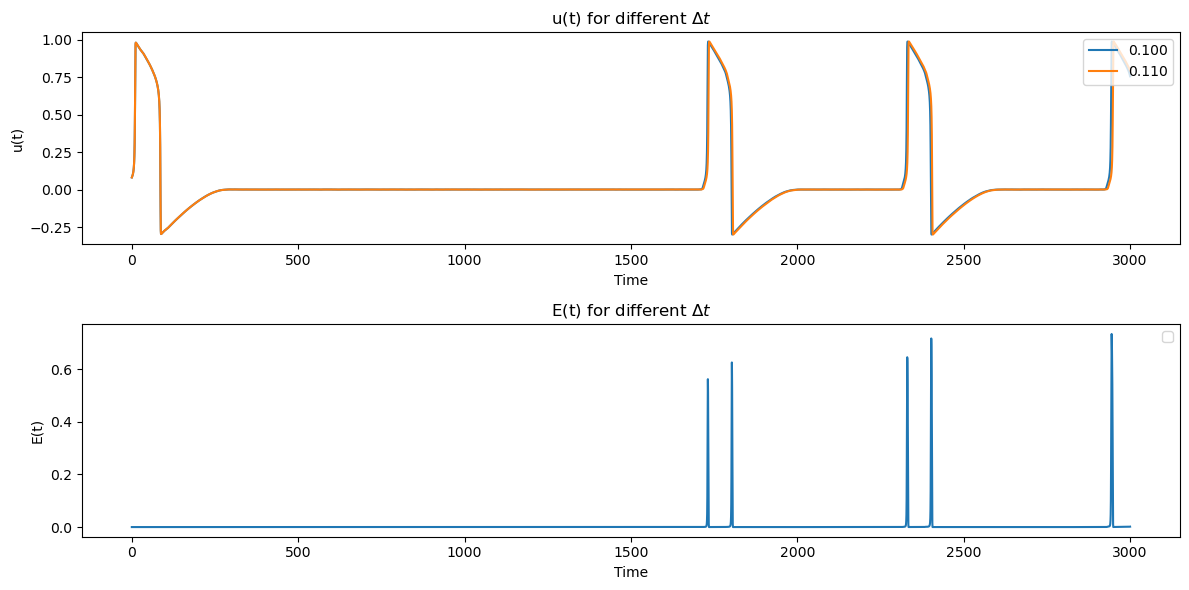

In [19]:

from scipy.interpolate import interp1d

time1=np.linspace(0, 3000, int(3000 / (0.1 )))
time2=np.linspace(0, 3000, int(3000 / (0.1 +  0.01)))
# Define the common time points
common_time = np.linspace(0, min(time1[-1], time2[-1]), num=min(len(time1), len(time2)))

# Interpolate both arrays to the common time points
interpolator1 = interp1d(time1, sol[0], kind='linear', fill_value="extrapolate")
interpolator2 = interp1d(time2, sol[1], kind='linear', fill_value="extrapolate")

sol1_common = interpolator1(common_time)
sol2_common = interpolator2(common_time)

# Perform the subtraction
s = (sol1_common - sol2_common)**2


for i in range(1):
    plt.figure(figsize=(12, 6))
    
    # Plot the time series
    plt.subplot(2, 1, 1)
    for j in range(2):
        plt.plot(np.linspace(0, 3000, int(3000 / (0.1 + j * 0.01))), sol[j][:], label=f"{0.1 + j * 0.01:.3f}")
    plt.xlabel('Time')
    plt.ylabel('u(t)')
    plt.legend(loc='upper right')
    plt.title(r'u(t) for different $\Delta t$')

    # Plot the histograms
    plt.subplot(2, 1, 2)
    '''
    for j in range(3):
        plt.hist(sol[j], bins=3000, alpha=0.75, label=r'$\Delta t$='+f'{0.05 + j * 0.01:.3f}', histtype='step')
        peak_values = sol[j][(sol[j] > -0.01) & (sol[j] < 0.01)]
        variance = np.var(peak_values)
        print(r'Variance of the peak around 0 for $\Delta t$'+f'={0.05 + j * 0.01:.3f}: {variance:.6f}')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.legend(loc='upper right')
    plt.xlim(-0.2, 0.2)
    plt.title(r'Histograms for different $\Delta t$ values')
    '''
    plt.subplot(2, 1, 2)
    for j in range(1):
        
        plt.plot(np.linspace(0, 3000, int(3000 / (0.1 + (j+1) * 0.01))), s)
    plt.xlabel('Time')
    plt.ylabel('E(t)')
    plt.legend(loc='upper right')
    plt.title(r'E(t) for different $\Delta t$')
    plt.tight_layout()
    plt.show()


In [ ]:
## Lipschifts constants
from jax.numpy.linalg import svd

# Define the partial derivatives of f and g
def jacobian_block(u, v, a, b, e):
    # Partial derivatives
    df_du = a * (3 * u**2 - 2 * (b + 1) * u + b)
    df_dv = -1
    dg_du = -e
    dg_dv = e

    # Jacobian block for each (u_i, v_i)
    return jnp.array([[df_du, df_dv], [dg_du, dg_dv]])

# Compute spectral norm of the Jacobian block
def spectral_norm(u, v, a, b, e):
    J = jacobian_block(u, v, a, b, e)
    _, singular_values, _ = svd(J)
    return jnp.max(singular_values)

# Test parameters
a=3
b=0.05 
e=1e-2  

# Compute K_f as the maximum spectral norm over all (u_i, v_i)
#K_f = max(spectral_norm(u_i, v_i, a, b, e) for u_i, v_i in zip(u, v))

#print("Lipschitz constant K_f:", K_f)
u_min= -0.3028501
u_max=0.9887498
v_max=0.43509236 
v_min=- 0.00055032555
u_values = jnp.linspace(u_min, u_max, 100)
v_values = jnp.linspace(v_min, v_max, 100)

K_f_global = max(
    spectral_norm(u, v, a, b, e) for u in u_values for v in v_values
)

print("Global Lipschitz constant K_f:", K_f_global)

#Global Lipschitz constant K_f: 3.0519285: this would lead to dt=0.00033 which doesn't seem right

Global Lipschitz constant K_f: 3.0519285


Variance of the peak around 0 for $\Delta t$=0.050: 0.000024
Variance of the peak around 0 for $\Delta t$=0.051: 0.000023
Variance of the peak around 0 for $\Delta t$=0.052: 0.000025

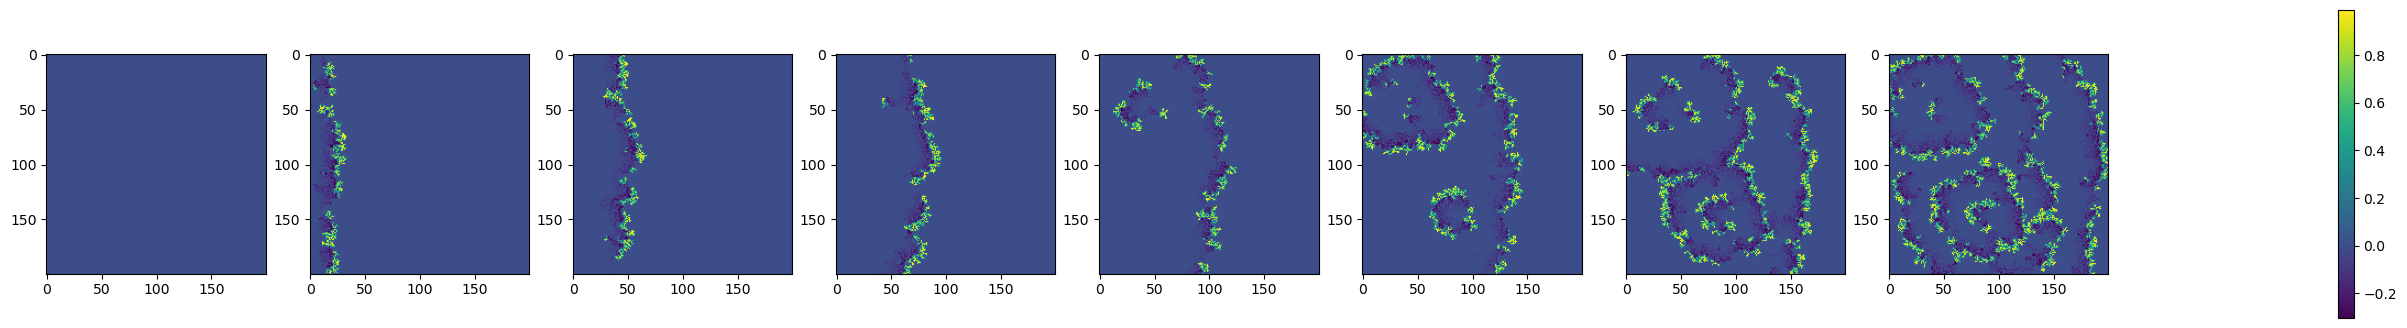

In [40]:
L1, c1=generate_laplacian(N_x, N_x, 0.5, sparse_matrix=True,seed=2)

u_sol, v_sol = run_simulation( N=N, L=L1, c1=c1, delta_t=0.1, total_time=3000, sigma=0.0001, key=random.PRNGKey(2))

fig, axs = plt.subplots(1,9,figsize=(30,4))
min = u_sol.min()
max = u_sol.max()
for i, ax in enumerate(axs[:-1]):
    im = ax.imshow(u_sol[int((i/len(axs)*int(3000/0.1))),:].reshape(N_x,N_y), vmin=min,vmax=max)
axs[-1].axis('off')
fig.colorbar(im, ax=axs[-1])

In [5]:
# functiom to calculate the rate of u by thresholding

def threshold_matrix(matrix: jnp.ndarray, threshold: float) -> jnp.ndarray:
    """
    Scans a JAX matrix and returns a binary matrix where elements above 
    the threshold are 1 and elements below or equal to the threshold are 0.
    
    Parameters:
    matrix (jnp.ndarray): Input JAX matrix.
    threshold (float): Threshold value.
    
    Returns:
    jnp.ndarray: A binary matrix of the same shape as the input.
    """
    # Use jax.numpy.where to create a binary matrix
    return jnp.where(matrix > threshold, 1, 0)


In [6]:


@jit
def process_element_rate(array, i, j):
    '''
    Process a single element of a binary array to calculate its Shannon entropy.

    Parameters:
    matrix (jax.numpy.ndarray): A binary matrix of shape (N_x,N_y, T),
                                where N_x*N_y is the number of nodes, and T is the number of time steps. 
    i,j : index of the element

    Returns:
    entropy (float): The Shannon entropy of the element.
    '''
    n = 12000
    p_0 = jnp.sum(array[i,j,:] == 0) / n
    p_1 = 1 - p_0  # Since p_0 + p_1 = 1
    p_0 = jnp.clip(p_0, 1e-12, 1.0)  # Avoid log(0)
    p_1 = jnp.clip(p_1, 1e-12, 1.0)  # Avoid log(0)
    
    # Calculate entropy
    entropy = - (p_0 * jnp.log2(p_0) + p_1 * jnp.log2(p_1))

    return entropy


def rate_entropy(array, c1):
    '''
    Calculate the average Shannon entropy of the elements of a binary array disregarding the ones that are conduction blocks.
    Parameters: 
    array (jax.numpy.ndarray): A binary matrix of shape (N_x,N_y, T),
    c1 (jax.numpy.ndarray): A binary matrix of shape (N_x,N_y) where True values indicate conduction blocks.
    
    Returns: 
    average_entropy (float): The average Shannon entropy of the elements of the array.
    '''
    N, M, T = array.shape
    
    # Vectorized processing of all elements
    vectorized_process = vmap(lambda i: vmap(lambda j: process_element_rate(array, i, j))(jnp.arange(M)))(jnp.arange(N))
    # Mask out elements where c1 is True
    masked_entropy = jnp.where(c1, jnp.nan, vectorized_process)
    
    # Calculate the mean entropy, ignoring NaN values
    average_entropy = jnp.nanmean(masked_entropy)
    return average_entropy

#The entropy calculated this way is bullshit: I need to make an histogram of the activity and from that calculate a prob distribution
@jit
def activity_entropy(rate, c1): 
    '''
    Calculate the average Shannon entropy of the global activity of a binary array (1-> active, 0-> inactive) disregarding the elements that are conduction blocks.
    
    Parameters: array (jax.numpy.ndarray): A binary matrix of shape (N_x,N_y, T),
            c1 (jax.numpy.ndarray): A binary matrix of shape (N_x,N_y) where True values indicate conduction blocks.
    
    Returns: entropy (float): The Shannon entropy of the activity of the array.
             activity (jax.numpy.ndarray): The average activity of the array for each time step.
''' 
    # Broadcast c1 to match the shape of rate
    c1_broadcasted = jnp.broadcast_to(c1[:, :, None], rate.shape)
    masked_rate = jnp.where(c1_broadcasted, jnp.nan, rate)
    masked_rate = masked_rate.reshape(N_x * N_y, -1)
    activity = jnp.nanmean(masked_rate, axis=0)
    
    epsilon=1e-12 
    total_activity = jnp.sum(activity)
    p_act = activity / (total_activity + epsilon)
    entropy = -jnp.sum(p_act * jnp.log2(p_act + epsilon))

    return entropy, activity





In [7]:
@jit
def handle_blocks(array, c1):
    '''
    Calculate the average of an array disregarding the elements that are conduction blocks.
    Parameters:
    array (jax.numpy.ndarray): A matrix of shape N,
    c1 (jax.numpy.ndarray): A binary matrix of shape (N_x, N_y) where True values indicate conduction blocks.
    Returns:
    average (float): The average of the array disregarding the elements that are conduction blocks.
    '''
    c1=c1.reshape(N_x*N_y)
    # Mask out elements where c1 is True
    masked_entropy = jnp.where(c1, jnp.nan, array)
    
    # Calculate the mean entropy, ignoring NaN values
    average = jnp.nanmean(masked_entropy)
    return average


# This function needs to be double checked
@jit
def calculate_ais(matrix, c1):
    """
    Calculate the global Active Information Storage (AIS) for each node in the matrix summing over all time steps.

    Parameters:
        matrix (jax.numpy.ndarray): A binary matrix of shape (N, T),
                                    where N is the number of nodes, and T is the number of time steps.
        c1 (jax.numpy.ndarray): A binary matrix of shape (N_x, N_y) where True values indicate conduction blocks.

    Returns:
        average_ais (float): The average AIS value across all nodes.
    """
    N, T = matrix.shape

    # Extract past states (X_{t-1}) and current states (X_t)
    X_t_minus_1 = matrix[:, :-1]  # Shape (N, T-1)
    X_t = matrix[:, 1:]          # Shape (N, T-1)

    # Encode joint states (X_{t-1}, X_t) as integers in range 0-3: 0 = (0,0), 1 = (0,1), 2 = (1,0), 3 = (1,1)
    joint_states = X_t_minus_1 * 2 + X_t  # Shape (N, T-1)

    # Compute joint probabilities P(X_{t-1}, X_t)
    joint_probs = jnp.array([(joint_states == i).mean(axis=1) for i in range(4)]).T  # Shape (N, 4)

    # Reshape joint probabilities into 2x2 matrices for each node
    joint_probs = joint_probs.reshape(N, 2, 2)  # Shape (N, 2, 2)

    # Compute marginal probabilities P(X_t)
    p_x_t = jnp.sum(joint_probs, axis=1)  # Marginalize over X_{t-1}, shape (N, 2)

    # Compute conditional probabilities P(X_t | X_{t-1})
    p_x_t_given_x_t_minus_1 = joint_probs / jnp.sum(joint_probs, axis=2, keepdims=True)  # Shape (N, 2, 2)

    # Calculate AIS using the pointwise formula
    # Broadcast joint_probs and p_x_t to compute: P(X_{t-1}, X_t) * log(P(X_t | X_{t-1}) / P(X_t))
    log_term = jnp.log(p_x_t_given_x_t_minus_1 / p_x_t[:, jnp.newaxis, :])  # Shape (N, 2, 2)
    log_term = jnp.where(jnp.isfinite(log_term), log_term, 0.0)  # Handle log(0) or division by 0

    ais_values = jnp.sum(joint_probs * log_term, axis=(1, 2))  # Sum over all (X_{t-1}, X_t)
    average_ais=handle_blocks(ais_values, c1)

    return average_ais



In [ ]:

# function to calculate the average of u for each time step disregarding the elements that are conduction blocks
@jit
def compute_averages(u_sol, c1_flat):
    """
    Compute the average of the elements that are False in c1 for each time step in u_sol.
    
    Parameters:
    - u_sol (jax.numpy.ndarray): The solution array of shape (T, N).
    - c1_flat (jax.numpy.ndarray): The conduction block array of shape (N_x,N_y).
    
    Returns:
    - averages (jax.numpy.ndarray): The array of averages for each time step.
    """
    # Vectorized computation of averages
    averages = vmap(lambda u_t: handle_blocks(u_t, c1_flat))(u_sol)
    return averages

# Compute the averages
#averages = compute_averages(u_sol, c1)


In [8]:
ais=[]
for conduction_threshold in jnp.arange(0, 0.9, 0.01):
    seed_laplacian = int(conduction_threshold * 10) 
    seed_noise = int(conduction_threshold * 100)
    L1, c1 = generate_laplacian(N_x, N_x, conduction_block_threshold=conduction_threshold, sparse_matrix=True, seed=seed_laplacian)
    u_sol, v_sol = run_simulation(N=N, L=L1, c1=c1, sigma=0.0001, delta_t=0.1, key=random.PRNGKey(seed_noise))
    rate = threshold_matrix(u_sol, 0.08)
    rate = rate.T
    ais.append(calculate_ais(rate, c1))
ais = jnp.array(ais)

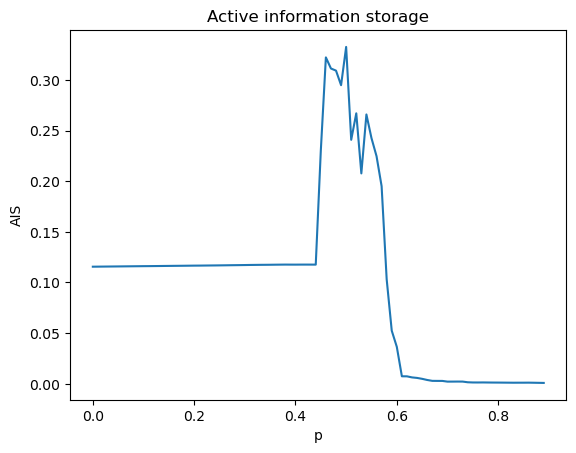

In [9]:
plt.plot(np.arange(0,0.90,0.01),ais)
#plt.plot(np.arange(0,0.90,0.01),results_v,label='Entropy of v')
plt.xlabel('p')
plt.ylabel('AIS')

plt.title('Active information storage')
plt.show()

In [ ]:
#function to calculate the average rate

@jit
def handle_blocks_rate(array, c1):
    '''
    Calculate the average of an array disregarding the elements that are conduction blocks.
    Parameters:
    array (jax.numpy.ndarray): A matrix of shape (N),
    c1 (jax.numpy.ndarray): A binary matrix of shape (N_x, N_y) where True values indicate conduction blocks.
    Returns:
    average (float): The average of the array disregarding the elements that are conduction blocks.
    '''
    c1=c1.reshape(N_x*N_y)
    
    # Calculate the mean entropy, ignoring NaN values
    c1_broadcasted = jnp.broadcast_to(c1[:,  None], array.shape)
    masked_rate = jnp.where(c1_broadcasted, jnp.nan, array)
    
    average = jnp.nanmean(masked_rate)
    return average

In [51]:
#calculate the average rate as a function of p
rate_1=[]
for conduction_threshold in jnp.arange(0, 0.9, 0.01):
    seed_laplacian = int(conduction_threshold * 10) 
    seed_noise = int(conduction_threshold * 100)
    L1, c1 = generate_laplacian(N_x, N_x, conduction_block_threshold=conduction_threshold, sparse_matrix=True, seed=seed_laplacian)
    u_sol, v_sol = run_simulation(N=N, L=L1, c1=c1,delta_t=0.1, sigma=0.0001, key=random.PRNGKey(seed_noise))
    rate = threshold_matrix(u_sol, 0.08)
    rate = rate.T
    rate_1.append(handle_blocks_rate(rate, c1))
rate_1 = jnp.array(rate_1)


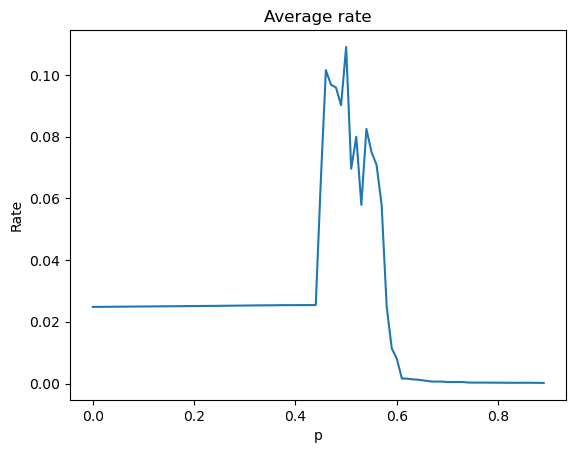

In [52]:
plt.plot(np.arange(0,0.90,0.01),rate_1)
#plt.plot(np.arange(0,0.90,0.01),results_v,label='Entropy of v')
plt.xlabel('p')
plt.ylabel('Rate')

plt.title('Average rate')
plt.show()

In [10]:
entropy_u=[]
rate_act=[]
com_act=[]
for conduction_threshold in jnp.arange(0, 0.9, 0.01):
    seed_laplacian = int(conduction_threshold * 10) 
    seed_noise = int(conduction_threshold * 100)
    L1, c1 = generate_laplacian(N_x, N_x, conduction_block_threshold=conduction_threshold, sparse_matrix=True, seed=seed_laplacian)
    u_sol, v_sol = run_simulation(N=N, L=L1, c1=c1,delta_t=0.1, sigma=0.0001, key=random.PRNGKey(seed_noise))
    rate = threshold_matrix(u_sol, 0.08)
    rate = rate.T
    rate = rate.reshape(N_x, N_y, -1)
    entropy_u.append(rate_entropy(rate, c1))
    entr_act, activity = activity_entropy(rate, c1)
    rate_act.append(activity)
    com_act.append(compute_averages(u_sol, c1))

In [12]:
np.savetxt('rate_cativiity.txt', rate_act, fmt='%.6f', header=f'Rate')
np.savetxt('complex_cativiity.txt', com_act, fmt='%.6f', header=f'com')


In [ ]:
# calculate the pmf of the average rate 

def calculate_pmf(array):
    """
    Returns the probability mass function (pmf) of the input array.
    
    Parameters:
    array (numpy.ndarray): Input array of data.
    
    Returns:
    numpy.ndarray: The pmf of the input array.
    """
    
    # Calculate frequencies
    unique, counts = jnp.unique(array, return_counts=True)
    frequencies = counts / len(array)
    
    return frequencies

def entropy_pmf(data):
    '''
    Calculate the entropy of a dataset with discrete values.
    Parameters:
    data (jax.numpy.ndarray): dataset with discrete values.
    Returns:
    float: The entropy of the pmf of the dataset.
    '''
    prob=calculate_pmf(data)
    epsilon = 1e-12  # Small constant to prevent division by zero
    
    entropy = -jnp.sum(prob * jnp.log2(prob + epsilon))  # Calculate entropy
    return jnp.abs(entropy)  # Ensure entropy is not negative


In [ ]:
# Calculate the pdf for the average u and then the entropy with kernel density estimation
def adaptive_bandwidth(data):
    """
    Compute bandwidth using an IQR-based rule for multimodal distributions.
    """
    n = data.size
    std_dev = jnp.std(data)
    iqr = jnp.percentile(data, 75) - jnp.percentile(data, 25)
    return 0.9 * jnp.minimum(std_dev, iqr / 1.34) * (n ** (-1 / 5))



def compute_pdf(data, kernel="gaussian", bandwidth=None, num_points=100):
    """
    Compute the probability density function (PDF) of the data using KDE.
    
    Parameters:
        data (array-like): Input data points (1D array).
        kernel (str): The kernel type ("gaussian", "epanechnikov", "exponential").
        bandwidth (float or None): The bandwidth for the kernel. If None, defaults to Silverman's rule.
        num_points (int): Number of points for the output PDF.

    Returns:
        grid (jnp.ndarray): Points where the PDF is evaluated.
        pdf (jnp.ndarray): Estimated probability density values.
    """
    data = jnp.array(data)
    
    # Define kernel functions
    def gaussian_kernel(x, y, h):
        """Gaussian kernel."""
        u = (x - y) / h
        return jnp.exp(-0.5 * u**2) / (jnp.sqrt(2 * jnp.pi) * h)
    
    def epanechnikov_kernel(x, y, h):
        """Epanechnikov kernel."""
        u = (x - y) / h
        return 0.75 * (1 - u**2) * (jnp.abs(u) <= 1) / h

    def exponential_kernel(x, y, h):
        """Exponential kernel."""
        u = jnp.abs(x - y) / h
        return jnp.exp(-u) / (2 * h)

    # Select the kernel function
    if kernel == "gaussian":
        kernel_func = gaussian_kernel
    elif kernel == "epanechnikov":
        kernel_func = epanechnikov_kernel
    elif kernel == "exponential":
        kernel_func = exponential_kernel
    else:
        raise ValueError(f"Unsupported kernel: {kernel}")
    
    # Bandwidth selection usinng IQR-based rule
    if bandwidth is None:
        bandwidth = adaptive_bandwidth(data)

    # Generate equally spaced points for the PDF
    x_vals = jnp.linspace(jnp.min(data), jnp.max(data), num_points)

    # Compute KDE using the selected kernel
    def kde(x):
        return jnp.mean(kernel_func(x, data, bandwidth))

    pdf_vals = jax.vmap(kde)(x_vals)

    return x_vals, pdf_vals

def entropy_pdf(data, kernel="gaussian", bandwidth=None, num_points=100000):
    '''
    Calculate the entropy of a probability distribution.
    Parameters:
    data (jax.numpy.ndarray): data points.
    kernel (str): The kernel type ("gaussian", "epanechnikov", "exponential").
    bandwidth (float or None): The bandwidth for the kernel. If None, defaults to IQR based rule.
    num_points (int): Number of points for the PDF.
    Returns:
    float: The entropy of the probability distribution.
    '''
    x_val, prob=compute_pdf(data, kernel='exponential', bandwidth=bandwidth, num_points=num_points)    
    epsilon = 1e-12  # Small constant to prevent division by zero
    
    entropy = -jnp.sum(prob * jnp.log2(prob + epsilon))  # Calculate entropy
    return jnp.abs(entropy)  # Ensure entropy is not negative



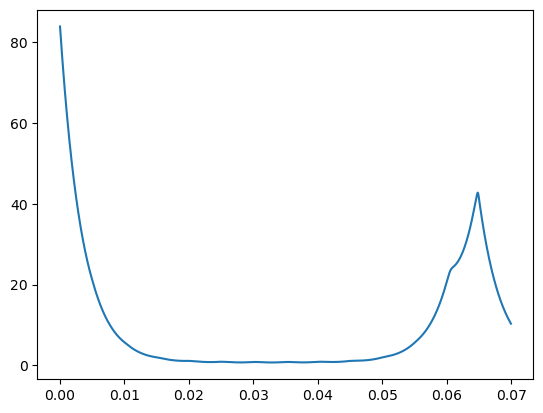

In [76]:
a,b=compute_pdf(rate_act[0,:], num_points=10000, kernel='exponential')
plt.plot(a, b)

Text(0.5, 1.0, 'Shannon entropy with Gaussian kernel')

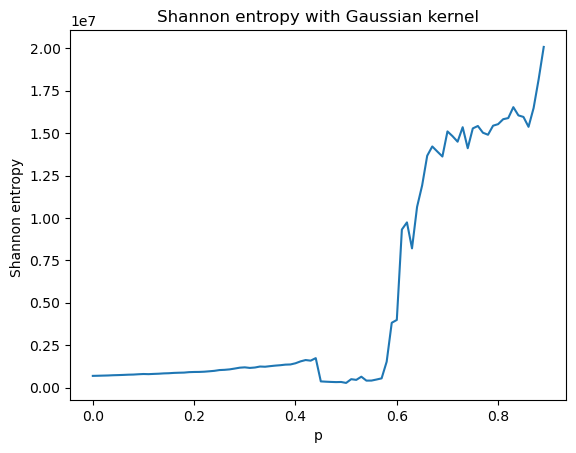

In [82]:
ent=[]
for i in range(90):
    ent.append(entropy_pdf(com_act[i, :], kernel='exponential', bandwidth=None, num_points=10000))
plt.plot(np.arange(0,0.9,0.01),ent)
plt.xlabel('p')
plt.ylabel('Shannon entropy ')
plt.title('Shannon entropy with Gaussian kernel')

In [ ]:
# compute pdf via explicit binning

def compute_pdf_hist(data, method="freedman-diaconis"):
    """
    Compute the PDF of the data using histogram binning with an optimal bin-width selection rule.
    
    Parameters:
        data (array-like): Input data points (1D array or list).
        method (str): Method to calculate bin width ('freedman-diaconis').
    
    Returns:
        bin_centers (array): Centers of the bins.
        pdf (array): Estimated PDF values at bin centers.
    """
    data = jnp.array(data)  # Ensure data is a JAX array
    
    def freedman_diaconis_bin_width(data):
        # Freedman-Diaconis rule: bin width = 2 * IQR(data) / (n^(1/3))
        q75, q25 = jnp.percentile(data, jnp.array([75, 25]))  # Compute IQR
        iqr = q75 - q25
        bin_width = 2 * iqr / (data.size ** (1/3))
        return bin_width
    
    if method == "freedman-diaconis":
        bin_width = freedman_diaconis_bin_width(data)
    else:
        raise ValueError("Unsupported method. Only 'freedman-diaconis' is implemented.")
    
    # Determine bin edges
    data_min, data_max = jnp.min(data), jnp.max(data)
    num_bins = int(jnp.ceil((data_max - data_min) / bin_width))
    bin_edges = jnp.linspace(data_min, data_max, num_bins + 1)
    
    # Compute histogram
    hist, _ = jnp.histogram(data, bins=bin_edges, density=False)
    # Normalize the histogram to sum up to 1
    hist /= jnp.sum(hist)
    
    # Convert histogram to PDF
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    return bin_centers, hist


def compute_pdf_binning(data, num_bins=173, range=None, density=True):
    """
    Compute the PDF of the data using explicit square root binning.
    
    Parameters:
        data (array-like): Input data points (1D array).
        num_bins (int): Number of bins for the histogram.
        range (tuple or None): The range of the bins (min, max). If None, it uses (data.min(), data.max()).
        density (bool): If True, normalize the histogram to represent a PDF. Otherwise, raw counts.

    Returns:
        bin_centers (jnp.ndarray): Centers of the bins.
        pdf (jnp.ndarray): Estimated PDF (or raw counts if density=False).
    """
    data = jnp.array(data)

    # Determine bin edges
    if range is None:
        range = (jnp.min(data), jnp.max(data))
    
    bin_edges = jnp.linspace(range[0], range[1], num_bins + 1)

    # Digitize the data into bins and retrieve counts
    hist_counts = jnp.histogram(data, bins=bin_edges, density=False)[0]
    #normalize the histogram to sum up to 1
    hist_counts=hist_counts/jnp.sum(hist_counts)
    
    # Calculate bin centers
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

    return bin_centers, hist_counts


def entropy_hist(data):
    '''
    Calculate the entropy of a probability distribution obtained by binning a continueous variable.
    Parameters:
    data (jax.numpy.ndarray): data points.
    Returns:
    float: The entropy of the probability distribution obtained from the data points.
    '''
    x_val, prob=compute_pdf_hist(data)    
    epsilon = 1e-12  # Small constant to prevent division by zero
    
    entropy = -jnp.sum(prob * jnp.log2(prob + epsilon))  # Calculate entropy
    return jnp.abs(entropy)  # Ensure entropy is not negative



Text(0.5, 1.0, 'Shannon entropy histogram binning')

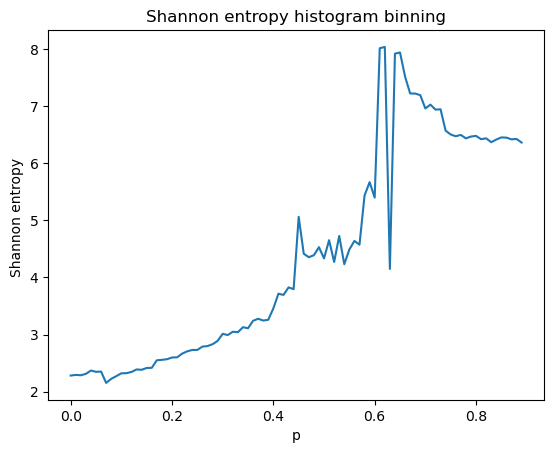

In [120]:
ent=[]
for i in range(90):
    ent.append(entropy_hist(com_act[i, :]))
plt.plot(np.arange(0,0.9,0.01),ent)
plt.xlabel('p')
plt.ylabel('Shannon entropy ')
plt.title('Shannon entropy histogram binning')

In [ ]:
#very big loop for multiple realisations, to consider later on


results_u = []
activity_t=[]
entropy_activity=[]

# Loop over conduction threshold values
for conduction_threshold in jnp.arange(0, 0.9, 0.01):
    results=0
    act=0
    ent_act=0
    file_name = f'u_sol_threshold_{conduction_threshold:.2f}.txt'
    for _ in range(5):
        seed_laplacian = int(conduction_threshold * 10) + _
        seed_noise = int(conduction_threshold * 100) + _

        L1, c1 = generate_laplacian(N_x, N_x, conduction_block_threshold=conduction_threshold, sparse_matrix=True, seed=seed_laplacian)
    
        u_sol, v_sol = run_simulation(N=N, L=L1, c1=c1, key=random.PRNGKey(seed_noise))
        

        # Save u_sol to the file
        np.savetxt(file_name, u_sol, fmt='%.6f', header=f'Realisation: {_}')

        rate = threshold_matrix(u_sol, 0.08)
        rate = rate.T
        rate = rate.reshape(N_x, N_y, -1)

        avg_entropy_u = rate_entropy(rate, c1)
        results+=avg_entropy_u
        entr_act, activity = activity_entropy(rate, c1)
        ent_act+=entr_act
        act+=activity
    results=results/5
    ent_act=ent_act/5
    act=act/5
    results_u.append(results)
    entropy_activity.append(ent_act)
    activity_t.append(act)



results_u = jnp.array(results_u)
entropy_activity = jnp.array(entropy_activity)
activity_t=jnp.array(activity_t)

45 7


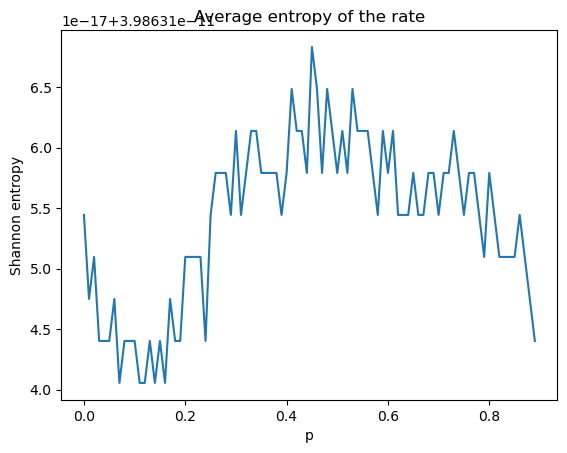

In [11]:

print(np.argmax(entropy_u), np.argmin(entropy_u))

plt.plot(np.arange(0,0.90,0.01),entropy_u)
#plt.plot(np.arange(0,0.90,0.01),results_v,label='Entropy of v')
plt.xlabel('p')
plt.ylabel('Shannon entropy')
#plt.legend()
plt.title('Average entropy of the rate')
plt.show()

Text(0.5, 1.0, 'Activity over time')

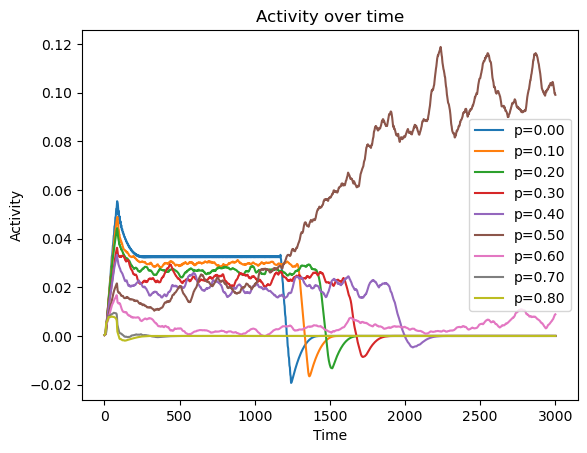

In [15]:
dts=int(3000/0.1)
com_act=np.array(com_act)
for i in np.arange(0, 0.90, 0.10):
    plt.plot(np.linspace(0,3000, dts), com_act[int(i * 100), :], label=f'p={i:.2f}')
plt.xlabel('Time')
plt.ylabel('Activity')
plt.legend()
plt.title('Activity over time')


Text(0.5, 1.0, 'Activity over time')

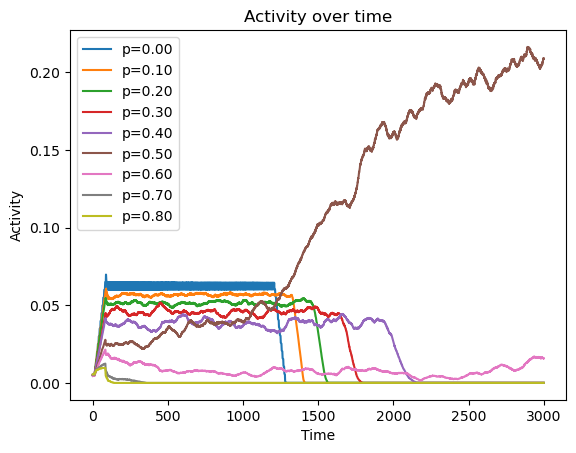

In [56]:
dts=int(3000/0.25)
for i in np.arange(0, 0.90, 0.10):
    plt.plot(np.linspace(0,3000, dts), activity_t[int(i * 100), :], label=f'p={i:.2f}')
plt.xlabel('Time')
plt.ylabel('Activity')
plt.legend()
plt.title('Activity over time')


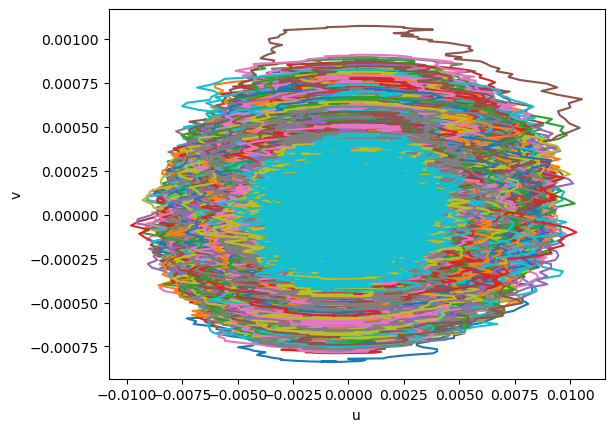

20010


In [61]:

c1 = c1.flatten()
u_sol=u_sol.T
v_sol=v_sol.T
##u_plot = np.array(u_sol[~c1, :])
#v_plot = np.array(v_sol[~c1, :])
u_plot = np.array(u_sol[c1, :])
v_plot = np.array(v_sol[c1, :])

# Plotting function
def plot_uv(u, v):
    plt.plot(u, v)  

# Plot each (u, v) pair for a subsample
#subsample_indices = np.random.choice(len(u_plot), size=100, replace=False)
for idx in range(len(u_plot)):
    plot_uv(u_plot[idx], v_plot[idx])

plt.xlabel('u')
plt.ylabel('v')
plt.show()
print(len(u_plot))

In [ ]:
# entropy calculations without going to rate or activity
@jit
def calculate_entropy(power_spectrum):
    '''
    Calculate the entropy of a power spectrum.
    Parameters:
    power_spectrum (jax.numpy.ndarray): The power spectrum of a signal.
    Returns:
    float: The entropy of the power spectrum.
    '''
    epsilon = 1e-12  # Small constant to prevent division by zero
    
    entropy = -jnp.sum(power_spectrum * jnp.log(power_spectrum + epsilon))  # Calculate entropy
    return jnp.abs(entropy)  # Ensure entropy is not negative


@jit
def process_element(array, i, j):
    '''
    Process a single element of an array to calculate its Shannon entropy.
    '''
    fft_result_shifted = jnp.fft.fftshift(jnp.fft.fft(array[i, j, :]))  # FFT and shift in one line
    power_spectrum = jnp.abs(fft_result_shifted) ** 2
    epsilon = 1e-12  # Small constant to prevent division by zero
    power_spectrum /= jnp.sum(power_spectrum) + epsilon  # Normalize power spectrum
    
    # Check if the power spectrum is normalized
    power_spectrum_sum = jnp.sum(power_spectrum)
    power_spectrum_normalized = jnp.allclose(power_spectrum_sum, 1.0, atol=1e-5)
    
    # Calculate entropy or return NaN if not normalized
    entropy = lax.cond(
        power_spectrum_normalized,
        lambda _: calculate_entropy(power_spectrum),
        lambda _: jnp.nan,
        operand=None
    )
    return entropy


def average_entropy(array, c1):
    '''
    Calculate the average Shannon entropy of the power spectrum of the elements of an array disregarding the ones that are conduction blocks.
    Parameters:
    - array (jax.numpy.ndarray): A 3D array of shape (N, M, T) where N is the number of rows, M is the number of columns, and T is the number of time steps.
    - c1 (jax.numpy.ndarray): A binary matrix of shape (N, M) where True values indicate conduction blocks.
    Returns:
    - average_entropy (float): The average Shannon entropy of the power spectrum of the elements of the array.
    '''
    N, M, T = array.shape
    
    # Vectorized processing of all elements
    vectorized_process = vmap(lambda i: vmap(lambda j: process_element(array, i, j))(jnp.arange(M)))(jnp.arange(N))
    # Mask out elements where c1 is True
    masked_entropy = jnp.where(c1, jnp.nan, vectorized_process)
    
    # Calculate the mean entropy, ignoring NaN values
    average_entropy = jnp.nanmean(masked_entropy)
    return average_entropy

'\n@jit\ndef process_element(array, i, j):\n    fft_result = jnp.fft.fft(array[i, j, :])\n    fft_result_shifted = jnp.fft.fftshift(fft_result)  # Shift the zero-frequency component to the center\n    power_spectrum = jnp.abs(fft_result_shifted) ** 2\n    epsilon = 1e-12  # Small constant to prevent division by zero\n    power_spectrum /= jnp.sum(power_spectrum) + epsilon  # Normalize power spectrum\n    entropy = calculate_entropy(power_spectrum)\n    return entropy\n\ndef average_entropy(array,c1):\n    N, M, T = array.shape\n    \n    # Vectorized processing of all elements\n    vectorized_process = vmap(lambda i: vmap(lambda j: process_element(array, i, j))(jnp.arange(M)))(jnp.arange(N))\n    \n    #false_count = jnp.sum(c1 == False)\n\n    # Create a mask for elements in array that are False in c1 and have 0 value for every t in T\n    #zero_mask = (array == 0).all(axis=2)\n    #false_count -= jnp.sum(zero_mask & ~c1)\n    average_entropy = jnp.mean(vectorized_process)\n    return

In [ ]:
results_u = []
results_v=[]

# Loop over conduction threshold values
for conduction_threshold in jnp.arange(0, 0.9, 0.01):
    seed = int(conduction_threshold * 10)
    L1, c1 = generate_laplacian(N_x, N_x, conduction_block_threshold=conduction_threshold,sparse_matrix=True, seed=seed)
    
    u_sol, v_sol = run_simulation( N=N, L=L1, c1=c1,key=random.PRNGKey(seed))
    u_sol = u_sol.T
    v_sol = u_sol.T

    u_sol=u_sol.reshape(N_x, N_y,-1)
    v_sol=v_sol.reshape(N_x, N_y, -1)

    
    avg_entropy_u = average_entropy(u_sol, c1)
    avg_entropy_v = average_entropy(v_sol, c1)
    
    results_u.append( avg_entropy_u)
    results_v.append(avg_entropy_v)

results_u = jnp.array(results_u)
results_v = jnp.array(results_v)

65 44
89 0


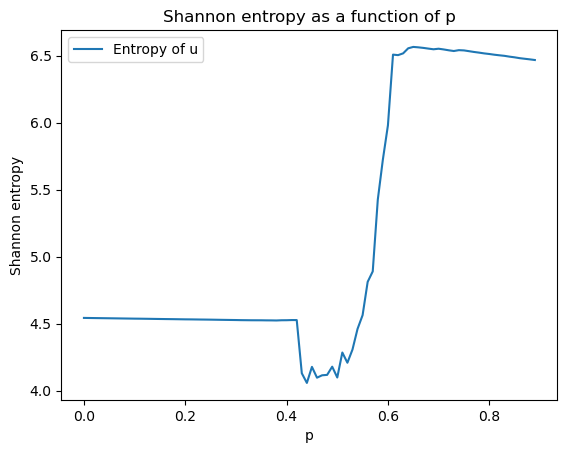

In [ ]:

print(np.argmax(results_u), np.argmin(results_u))
print(np.argmax(results_v), np.argmin(results_v))
plt.plot(np.arange(0,0.90,0.01),results_u,label='Entropy of u')
#plt.plot(np.arange(0,0.90,0.01),results_v,label='Entropy of v')
plt.xlabel('p')
plt.ylabel('Shannon entropy')
plt.legend()
plt.title('Shannon entropy as a function of p')
plt.show()

# Using Shark solver

In [3]:
from diffrax import ControlTerm, ShARK, MultiTerm, VirtualBrownianTree
import lineax
import jax.random as jr

In [4]:
def FHN_graph(t, y, args):
    N, a, b, e, Du, L,_ = args 
    u = y[:N]
    v = y[N:]
    
    du = a*u*(u-b)*(1-u) + Du*(L@u) - v 
    dv = e*(u-v)

    return jnp.append(du,dv)

def FHN_graph_noise(t, y, args):
    N, _, _, _, _,_, noise_amp = args 
    noise = noise_amp*jnp.ones((2*N))
    noise = noise.at[N:].set(0)
    return lineax.DiagonalLinearOperator(noise)

In [8]:


@jax.jit
def solve_brain(L,c1, y0='wave',a=3,b=0.05,e=0.01,Du=.04,T=1000, noise_amp=0, max_steps=1000000, solver=ShARK(),rtol=1e-2, atol=1e-4,dt0=1e-4, noise_tol=1e-6, pcoeff=0.1, icoeff=0.3, dcoeff=0):
    if y0 == 'wave':
        y0 = jnp.zeros(2 * N, dtype=jnp.float32)
        c1_flat = c1.flatten()
        for i in range(N):
            if i % N_x == 0 and not c1_flat[i]:
                y0 = y0.at[i].set(0.1)
    deterministic_term = ODETerm(FHN_graph)
    brownian_path = VirtualBrownianTree(0., T, tol=noise_tol, shape=(2*N,), key=jr.PRNGKey(0),levy_area=diffrax.SpaceTimeLevyArea)
    noise_term = ControlTerm(FHN_graph_noise,brownian_path)
    terms = MultiTerm(deterministic_term, noise_term)

    saveat = SaveAt(ts=jnp.linspace(0, T, 1000))
    stepsize_controller = diffrax.PIDController(rtol=rtol, atol=atol, pcoeff=pcoeff, dcoeff=dcoeff, icoeff=icoeff)

    sol = diffeqsolve(terms, solver, 0, T, dt0, y0, args=(N,a,b,e,Du,L, noise_amp), saveat=saveat,max_steps=max_steps, progress_meter=diffrax.TqdmProgressMeter(), stepsize_controller=stepsize_controller)
    return sol

In [9]:
y0 = jnp.zeros(2 * N, dtype=jnp.float32)
c1_flat = c1.flatten()
for i in range(N):
    if i % N_x == 0 and not c1_flat[i]:
        y0 = y0.at[i].set(0.1)

In [10]:
N=N_x*N_x
L1, c1=generate_laplacian(N_x, N_x, conduction_block_threshold=0,sparse_matrix=True, seed=2)
sol = solve_brain(L1,c1, y0=y0,T=3000)

100.00%|██████████| [08:50<00:00,  5.31s/%]


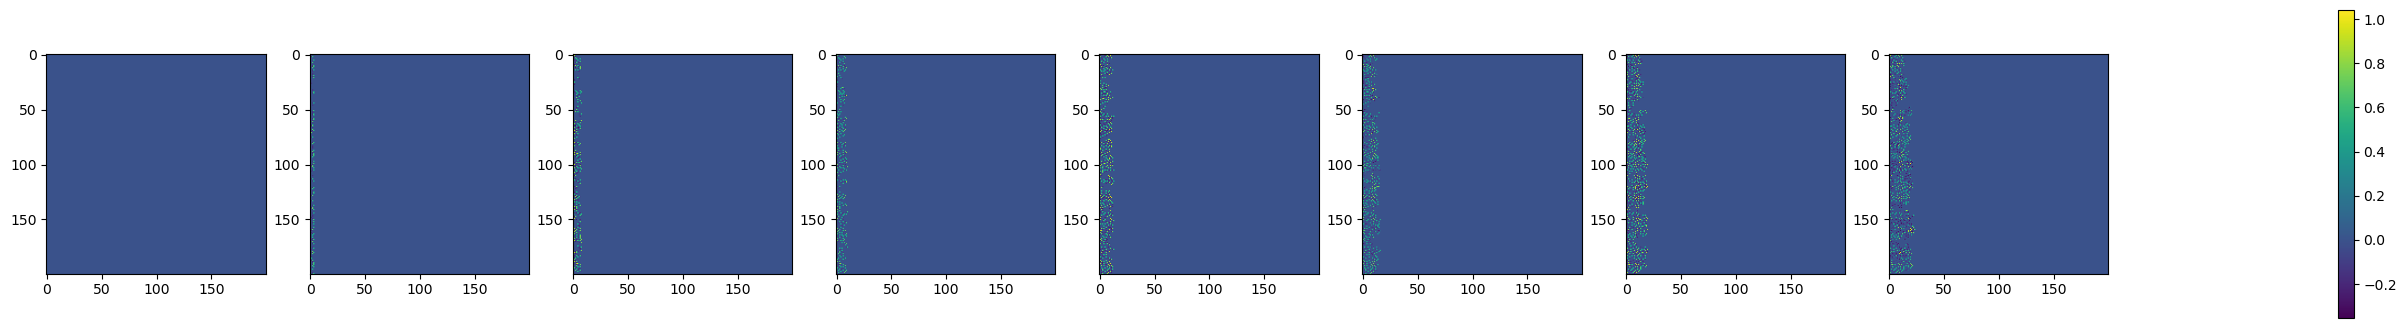

In [46]:
fig, axs = plt.subplots(1,9,figsize=(30,4))
min = sol.ys.min()
max = sol.ys.max()
for i, ax in enumerate(axs[:-1]):
    im = ax.imshow(sol.ys[int((i/len(axs)*1000)),:N].reshape(N_x,N_y), vmin=min,vmax=max)
axs[-1].axis('off')
fig.colorbar(im, ax=axs[-1])

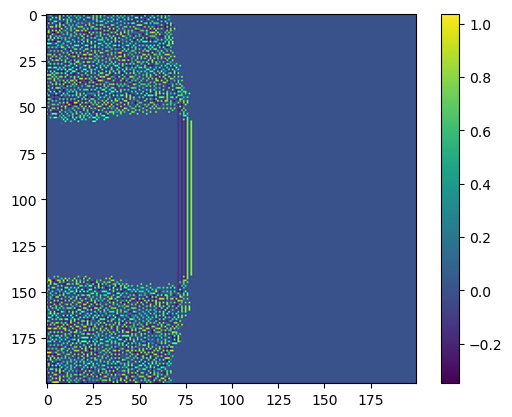

In [11]:
plt.imshow(sol.ys[-1,:N].reshape(N_x,N_y))
plt.colorbar()